In [ ]:
import pandas as pd
import numpy as np
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import Bio.Data.CodonTable
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast.Applications import NcbitblastxCommandline
import io
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
import os


In [ ]:
os.chdir("") # add path to data directory 

In [ ]:
# ortholog dataframe including ortholog IDs and life stage labels
path1 = 'lifestage_orthologs/'
#df = pd.read_csv(path1 + 'orthologs_simplified.csv')
df = pd.read_csv(path1 + 'breadth_orthologs_praefal_simplified.csv')
df = pd.read_csv(path1 + 'breadth_orthologs_reichenowi_simplified.csv')
# fasta with Pfal gene CDS sequences
#input_file = open(path1 + "pfal_CDS_extended.fasta")
input_file = open(path1 + "breadth_pfal_p_CDS.fasta")
input_file = open(path1 + "breadth_pfal_r_CDS.fasta")
pf = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
# fasta with Ppraefal gene CDS sequences
#input_file = open(path1 + "pprae_CDS.fasta")
input_file = open(path1 + "breadth_praefal_CDS.fasta")
input_file = open(path1 + "breadth_preich_CDS.fasta")
ppr = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
# standard DNA codon table
codons = Bio.Data.CodonTable.standard_dna_table.forward_table
codons['TAA'] = '*'
codons['TGA'] = '*'
codons['TAG'] = '*'

In [13]:
# CALCULATE NUMBER OF SYN AND NONSYN SITES FOR EACH CODON 
bases = ['A', 'T', 'G', 'C']
stop_codons = ['TAA', 'TAG', 'TGA']
sites = {} # {codon: (ns, s, ffd)}
for codon in codons: 
    if codon in stop_codons: 
        sites[codon] = [0, 0]
        continue
    s = 0 
    ns = 0
    aa = codons[codon]
    for i in range(3):
        ns_site = 0
        s_site = 0
        ffd = 0
        alt = [j for j in bases if j != codon[i]]
        #print(alt)
        first = codon[:i]
        last = codon[i+1:3]
        for a in alt: 
            new = first + a + last
            #print('new', new)
            # calling change to stop codon NS even though technically frameshift (ignoring frameshift vs missense diff)
            newAA = codons[new]
            if (newAA != aa): ns_site += 1
            else: s_site += 1
        total_alt = ns_site + s_site
        ns += ns_site / total_alt
        s += s_site / total_alt
        # check if FFD
        if (s_site == 3):
            ffd += s_site / total_alt 

    sites[codon] = [ns, s, ffd]

<Axes: xlabel='score_adj', ylabel='Count'>

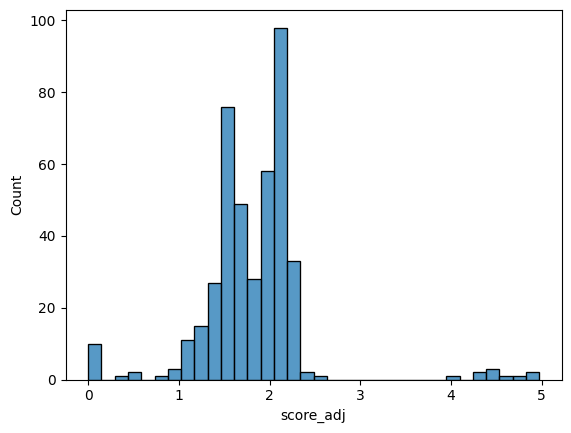

In [22]:
# approach: calcdiv on a per-gene basis
# initial function: get alignment quality for pairs 
def calcdiv(gene1, gene2):
    #print(gene1, gene2)
    ns = 0
    s = 0
    gene1 = 'cds_' + gene1
    gene2 = 'cds_' + gene2
    # perform local / global alignment of gene1 and gene2 
    s1 = str(pf[gene1].seq.translate())
    s1 = s1[s1.find('M'):s1.find('*')]
    s2 = str(ppr[gene2].seq.translate())
    s2 = s2[s2.find('M'):s2.find('*')]
    if len(s1) < 70 or len(s2) < 70: return(0)
    alignments = pairwise2.align.globalms(s1, s2, 5, -2, -3, -.5)
    #score_adj = (float(getattr(alignments[0], 'score'))) / (int(getattr(alignments[0], 'end')) - int(getattr(alignments[0], 'start')))
    score_adj = (float(getattr(alignments[0], 'score'))) / (np.min([len(s1), len(s2)]))
    return(score_adj)
    #return([ns, s])

scores = df.apply(lambda x: calcdiv(x['Pfal_gene'], x['Preich_gene']), axis=1)
df['score_adj'] = scores
df
import seaborn as sns
sns.histplot(df['score_adj'])


In [23]:
# examine alignments with mid-range scores
mid = df[np.logical_and(df['score_adj'] < 4, df['score_adj'] >2.7)]
mid

,Gene ID,Pfal_gene,Preich_gene,score_adj


In [24]:
# optionally calculate and show alignment characteristics
def calcdiv(gene1, gene2):
    #print(gene1, gene2)
    ns = 0
    s = 0
    gene1 = 'cds_' + gene1
    gene2 = 'cds_' + gene2
    # perform local / global alignment of gene1 and gene2 
    s1 = str(pf[gene1].seq.translate())
    s1 = s1[s1.find('M'):s1.find('*')]
    s2 = str(ppr[gene2].seq.translate())
    s2 = s2[s2.find('M'):s2.find('*')]
    if len(s1) < 70 or len(s2) < 70: return(0)
    alignments = pairwise2.align.globalms(s1, s2, 5, -2, -3, -.5)
    #score_adj = (float(getattr(alignments[0], 'score'))) / (int(getattr(alignments[0], 'end')) - int(getattr(alignments[0], 'start')))
    score_adj = (float(getattr(alignments[0], 'score'))) / (np.min([len(s1), len(s2)]))
    print(score_adj)
    print(format_alignment(*alignments[0]))
    return(score_adj)

mid.iloc[1:20,:].apply(lambda x: calcdiv(x['Pfal_gene'], x['Preich_gene']), axis=1)

,Gene ID,Pfal_gene,Preich_gene,score_adj


In [28]:
# filter out scores below minimum for quality 
min_score = 3.5
# for each Orthologous pair, keep alignment with best score in the case of multiple Praefal orthologs 
df = df[df['score_adj'] > min_score]
besthits = df.sort_values('score_adj', ascending=False).drop_duplicates(['Pfal_gene'])
print('Keeping only best P. reichenowi hits for each P. falciparum gene: ')

Keeping only best P. reichenowi hits for each P. falciparum gene: 


<Axes: xlabel='score_adj', ylabel='Count'>

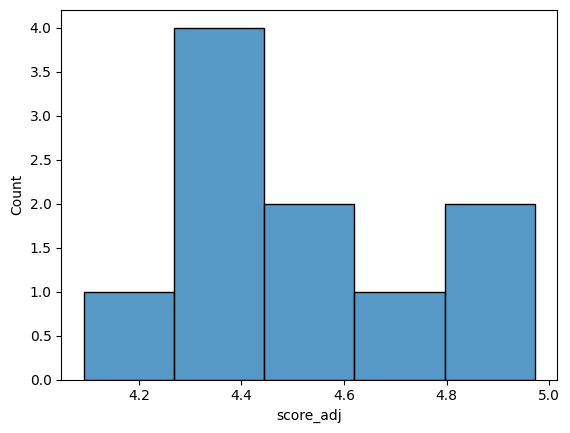

In [29]:
sns.histplot(besthits['score_adj'])

In [ ]:
# calculate divergence (via NS, S, and FFD changes and sites) for each best alignment
def calcdiv(gene1, gene2):
    #print(gene1, gene2)
    ns = 0
    s = 0
    ffd = 0
    ns_sites = 0
    s_sites = 0 
    ffd_sites = 0
    gene1 = 'cds_' + gene1
    gene2 = 'cds_' + gene2
    # perform local / global alignment of gene1 and gene2 
    ntA = pf[gene1].seq
    ntB = ppr[gene2].seq
    s1 = str(ntA.translate())
    # shift nt seqs to start codons -- should not need to crop to end 
    ntA = str(ntA)[(s1.find('M')*3):]
    s1 = s1[s1.find('M'):s1.find('*')]
    s2 = str(ntB.translate())
    ntB = str(ntB)[(s2.find('M')*3):]
    s2 = s2[s2.find('M'):s2.find('*')]
    alignments = pairwise2.align.globalms(s1, s2, 5, -2, -3, -.5)
    #print(format_alignment(*alignments[0]))
    seqA = getattr(alignments[0], 'seqA')
    seqB = getattr(alignments[0], 'seqB')
    #print(ntA)
    #print(ntB)
    # count AA (NS) and S differences 
    for i in range(len(seqA)):
        if seqA[i]=='-' or seqB[i]=='-': continue
        ns_i = seqA[i] != seqB[i] # increment ns with AA diff 
        ns += ns_i
        # calculate codon location in nt seq -- subtract gaps 
        gapA = seqA[0:i].count('-')
        gapB = seqB[0:i].count('-')
        #icodonA = np.floor_divide(i-gapA, 3)
        icodonA = (i-gapA)*3
        icodonB = (i-gapB)*3
        cA = ntA[icodonA:(icodonA+3)]
        cB = ntB[icodonB:(icodonB+3)]
        # count nt mismatches and increment s count
        if cA != cB: s += (sum(c1!=c2 for c1,c2 in zip(cA,cB)) - ns_i)
        # count FFD site changes if FFD sites > 0 
        if sites[cA][2]:
            # FFD sites by definition only at 3rd nt position of codon 
            if cA != cB: ffd += (cA[2] != cB[2])
        # getting site counts from P.falciparum 
        ns_sites += sites[cA][0]
        s_sites += sites[cA][1]
        ffd_sites += sites[cA][2]
    return([ns, s, ns_sites, s_sites, ffd, ffd_sites])

divs = besthits.apply(lambda x: calcdiv(x['Pfal_gene'], x['Preich_gene']), axis=1)
besthits['ns'] = [i[0] for i in divs]
besthits['s'] = [i[1] for i in divs]
besthits['ns_sites'] = [i[2] for i in divs]
besthits['s_sites'] = [i[3] for i in divs]
besthits['ffd'] = [i[4] for i in divs]
besthits['ffd_sites'] = [i[5] for i in divs]

In [ ]:
# save to divergence file of choice 
besthits.to_csv('breadth_divergence_by_gene_preich.csv')